# pfceval | Basic evaluation template

This notebooks shows how to do a basic evaluation for two synthetic forecasts.

### Prepare Evaluation reports

In [1]:
import pfceval
import polars as pl

from dataclasses import dataclass

@dataclass
class BasicEvalConfig():
    index_cols = ["valid_time", "station_id", "step"]
    eval_ths = [9, 12]
    save_dir = "."
    lead_time_col = "step"
    location_id_col = "station_id"
    ensemble_prefix = "pred_q"
    obs_col = "wind_speed"
    bootstrap_col = "run_id"
    n_bootstrap_iter = 10
    CI = 0.9

    construct_eval_reports = True

config = BasicEvalConfig()


def get_basic_evaluation_report(forecast, experiment_name):

    calc = pfceval.Calculator(forecast, config.index_cols)
    calc.add_absolute_error()
    calc.add_squared_error()
    # Add probabilistic metrics
    calc.add_variance()
    calc.add_crps()
    # Add threshold based metrics
    for th in config.eval_ths:
        calc.add_twcrps(th)
        calc.add_brier(th)

    # fill_evaluation is a quick way to create an Evaluation.
    # Custom evaluations also can be done without using it.
    report = pfceval.Evaluation.fill_evaluation(
        experiment_name=experiment_name,
        calculator=calc,
        lead_time_col=config.lead_time_col,
        location_id_col=config.location_id_col,
        bootstrap=True,
        n_iter=config.n_bootstrap_iter,
        CI=config.CI,
        location_metrics=True,
    )

    return report

# Generate psudo forecasts
forecast_paths = pfceval.utils.get_example_forecast_paths()

exp_names = []
for i, forecast_path in enumerate(forecast_paths):
    forecast = pfceval.Forecast(
        fc_path=forecast_path,
        ensemble_prefix=config.ensemble_prefix,
        obs_col=config.obs_col,
        bootstrap_cols=config.bootstrap_col,
        load_to_memory=True
    )

    exp_name = f"BasicEvaluationTemplate_{i}"
    exp_names.append(exp_name)
    report = get_basic_evaluation_report(
        forecast=forecast,
        experiment_name=exp_name
    )
    # Get metrics for the stations that is present in training data
    seen_report = get_basic_evaluation_report(
        forecast=forecast.filter(pl.col("unseen_sta") == False),
        experiment_name=exp_name
    )
    # Get metrics for the stations that is not present the training data
    unseen_report = get_basic_evaluation_report(
        forecast=forecast.filter(pl.col("unseen_sta") == True),
        experiment_name=exp_name
    )
    # Get a common report for all filters by combining them
    # The reports on right will have the right_prefix in their tables
    report.extend(seen_report, right_prefix="seen")
    report.extend(unseen_report, right_prefix="unseen")
    # Save the report to disk
    report.save_results(f"{config.save_dir}/{exp_name}")

### Load the evaluation reports and analyze 

In [2]:
# Read reports from location
reports = [pfceval.Evaluation.load_report(f"./{path}") for path in exp_names]

overall = pfceval.plotting.stack_overall_metrics(*reports)
overall.sort("mae")

experiment,twcrps_th:12,mae,brier_th:9,variance,mse,crps,brier_th:12,twcrps_th:9
str,f64,f64,f64,f64,f64,f64,f64,f64
"""BasicEvaluationTemplate_0""",0.25033,0.397419,0.000578,0.209965,0.217405,0.269436,0.019521,0.268893
"""BasicEvaluationTemplate_1""",0.279824,0.442332,0.000794,0.209441,0.269097,0.302175,0.021351,0.301596


In [3]:
unseen_overall = pfceval.plotting.stack_overall_metrics(*reports, table_name="unseen_overall_metrics")
unseen_overall.sort("mae")

experiment,twcrps_th:12,mae,brier_th:9,variance,mse,crps,brier_th:12,twcrps_th:9
str,f64,f64,f64,f64,f64,f64,f64,f64
"""BasicEvaluationTemplate_0""",0.253515,0.403267,0.000732,0.208617,0.222476,0.272317,0.017718,0.271809
"""BasicEvaluationTemplate_1""",0.280505,0.443171,0.000906,0.209006,0.270622,0.302778,0.020946,0.302164


In [4]:
seen_overall = pfceval.plotting.stack_overall_metrics(*reports, table_name="seen_overall_metrics")
seen_overall.sort("mae")

experiment,twcrps_th:12,mae,brier_th:9,variance,mse,crps,brier_th:12,twcrps_th:9
str,f64,f64,f64,f64,f64,f64,f64,f64
"""BasicEvaluationTemplate_0""",0.248207,0.39352,0.000475,0.210864,0.214024,0.267515,0.020723,0.266948
"""BasicEvaluationTemplate_1""",0.27937,0.441773,0.000718,0.209731,0.26808,0.301772,0.021621,0.301217


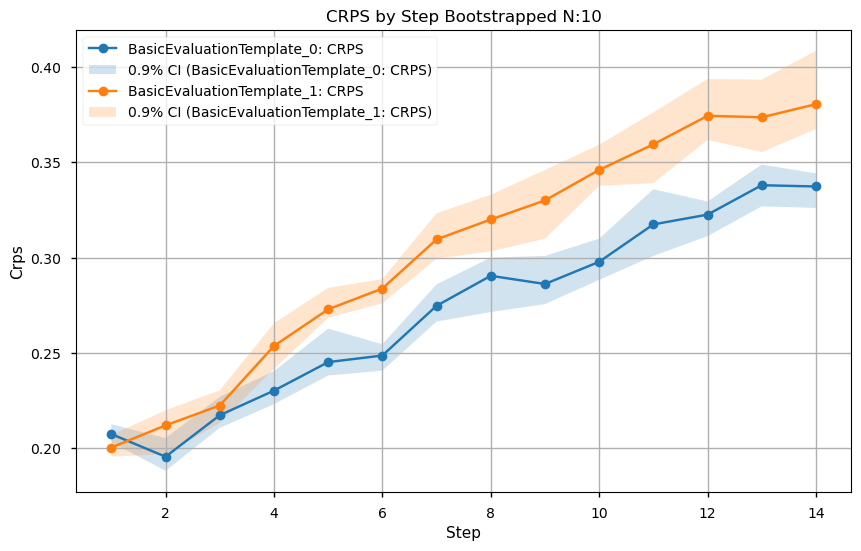

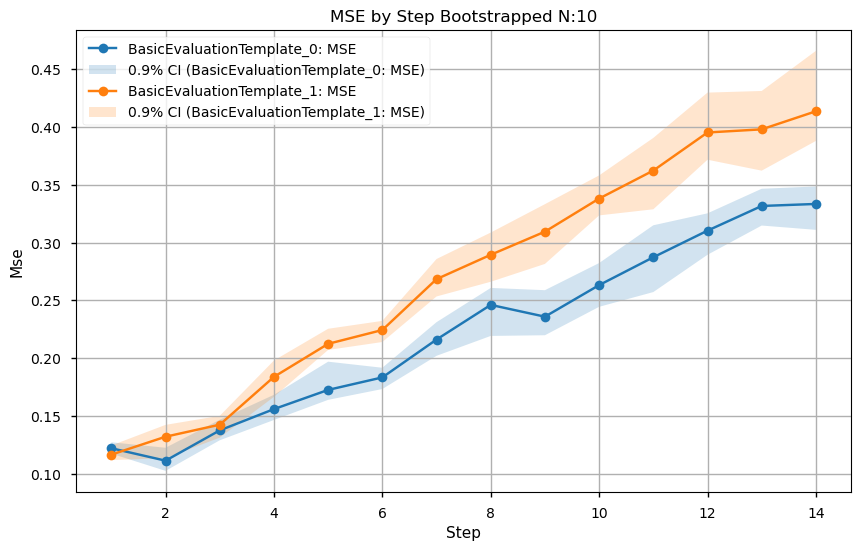

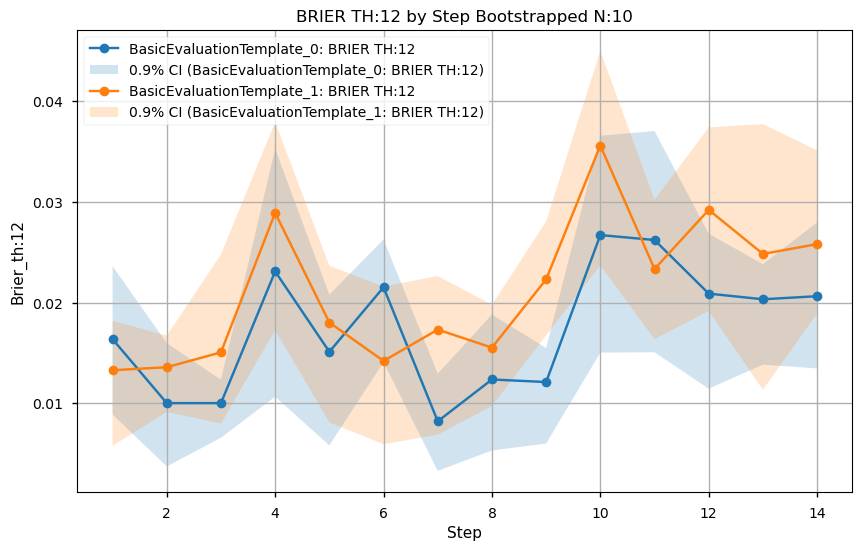

In [5]:
pfceval.plotting.plot_lead_time_metrics(*reports, table_name="unseen_bootstraped_lead_time_metrics", metrics=["crps", "mse", "brier_th:12"])

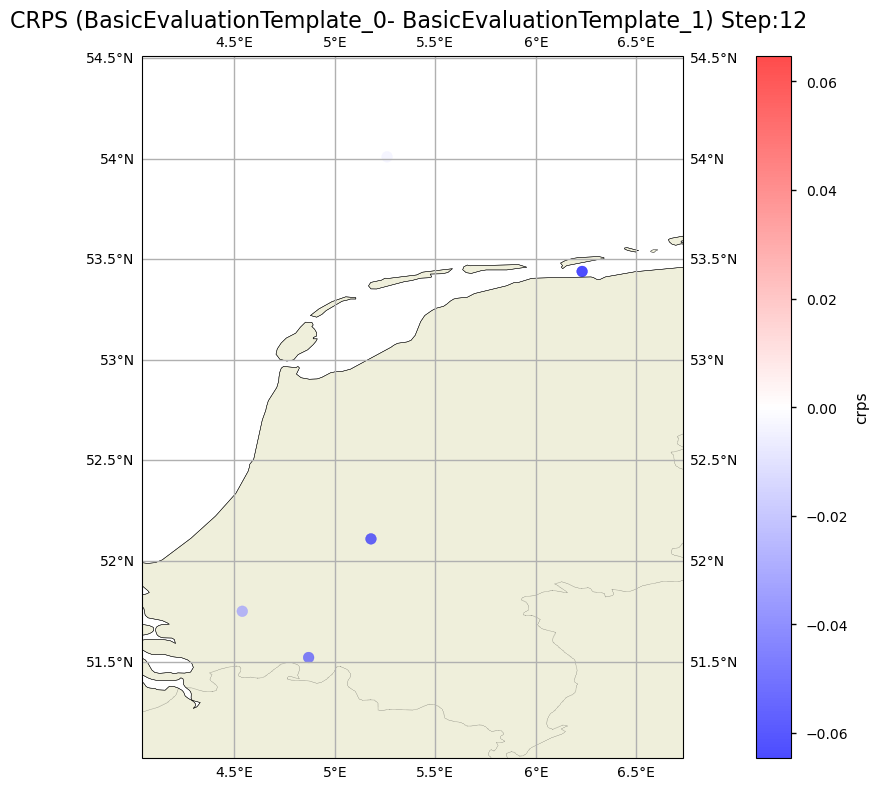

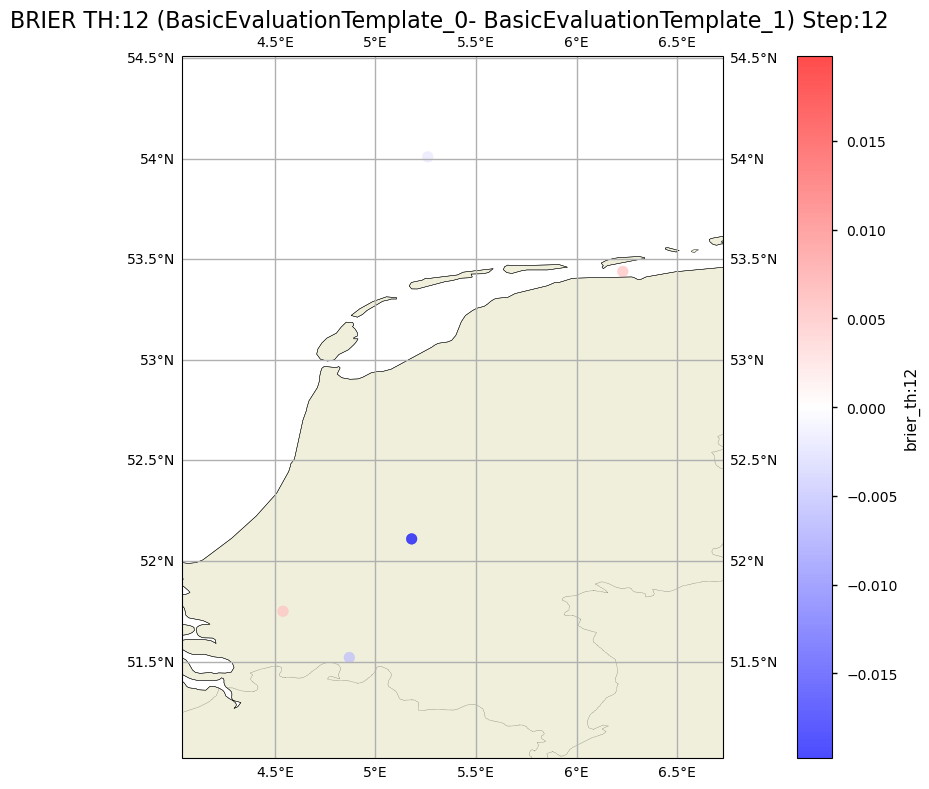

In [6]:
pfceval.plotting.plot_location_metrics(
    step=12,
    evaluation=reports[0],
    compare_with=reports[1],
    metrics=["crps", "brier_th:12"],
    cmap="bwr",
    dot_size=60,
    tol=0.5,
)

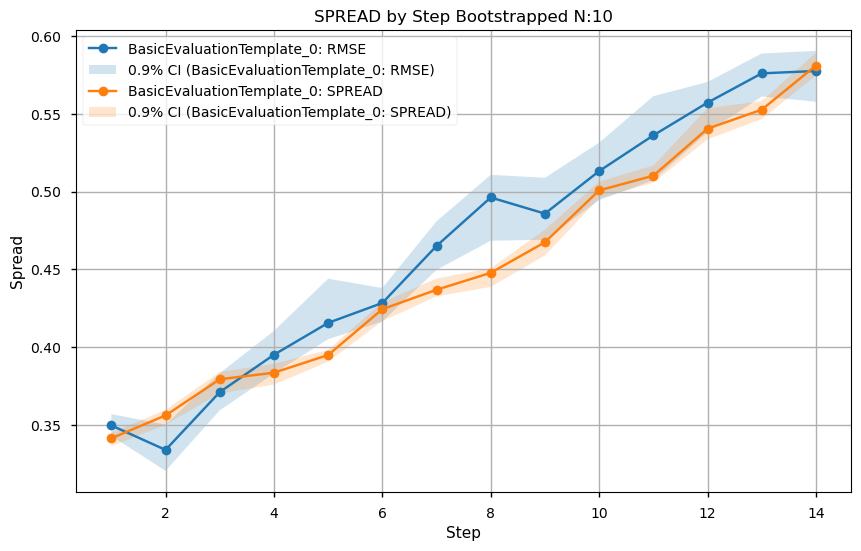

In [7]:
pfceval.plotting.plot_spread_rmse(reports[0], table_name="unseen_bootstraped_lead_time_metrics")

In [8]:
reports[0].tables()

['overall_metrics',
 'lead_time_metrics',
 'lead_time_location_metrics',
 'station_meta',
 'bootstraped_lead_time_metrics',
 'seen_overall_metrics',
 'seen_lead_time_metrics',
 'seen_lead_time_location_metrics',
 'seen_station_meta',
 'seen_bootstraped_lead_time_metrics',
 'unseen_overall_metrics',
 'unseen_lead_time_metrics',
 'unseen_lead_time_location_metrics',
 'unseen_station_meta',
 'unseen_bootstraped_lead_time_metrics']

In [9]:
reports[0]["unseen_bootstraped_lead_time_metrics"]

{'values': shape: (14, 25)
 ┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
 │ step      ┆ brier_th: ┆ brier_th: ┆ brier_th: ┆ … ┆ twcrps_th ┆ variance_ ┆ variance_ ┆ variance │
 │ ---       ┆ 12_mean   ┆ 12_q005   ┆ 12_q095   ┆   ┆ :9_q095   ┆ mean      ┆ q005      ┆ _q095    │
 │ duration[ ┆ ---       ┆ ---       ┆ ---       ┆   ┆ ---       ┆ ---       ┆ ---       ┆ ---      │
 │ μs]       ┆ f64       ┆ f64       ┆ f64       ┆   ┆ f64       ┆ f64       ┆ f64       ┆ f64      │
 ╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
 │ 1h        ┆ 0.016379  ┆ 0.008891  ┆ 0.023636  ┆ … ┆ 0.212693  ┆ 0.11653   ┆ 0.113051  ┆ 0.118942 │
 │ 2h        ┆ 0.010024  ┆ 0.00373   ┆ 0.015985  ┆ … ┆ 0.205405  ┆ 0.126776  ┆ 0.122569  ┆ 0.129329 │
 │ 3h        ┆ 0.010024  ┆ 0.006587  ┆ 0.012348  ┆ … ┆ 0.227026  ┆ 0.143863  ┆ 0.137013  ┆ 0.147401 │
 │ 4h        ┆ 0.023108  ┆ 0.010665  ┆ 0.035298  ┆ … ┆ 